In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd

def norm(x, norm, color, label, alpha=.8):
    plt.plot(x, norm(x), color=color, alpha=alpha, label=label)
    plt.plot(-x, norm(x), color=color, alpha=alpha)

In [2]:
fig_path = 'fig/'
os.makedirs(fig_path, exist_ok=True)

<Figure size 432x288 with 0 Axes>

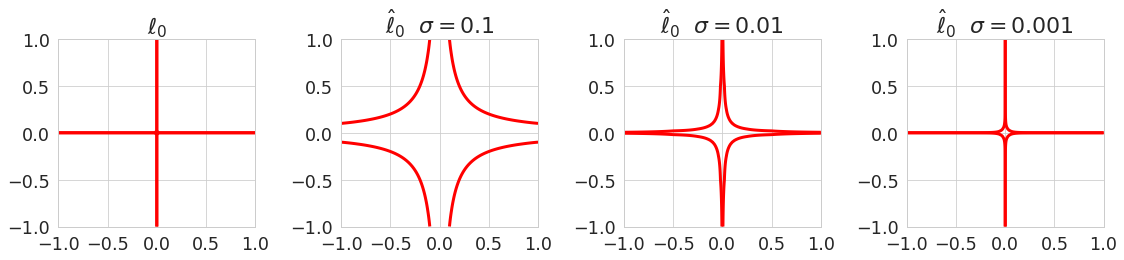

In [4]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.)
sns.despine(left=True)

xx, yy = np.meshgrid(np.linspace(-1, 1, num=101), np.linspace(-1, 1, num=101))

fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(16, 4))

#plot l_0
zz = (xx != 0).astype(int) + (yy != 0).astype(int)
axes[0].contour(xx,yy,zz, [1], colors='red', linewidths = 3) 
axes[0].set_title(f"$\ell_0$", fontsize=22)#, color='red') 
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(0.5))

for sigma, ax in zip([1e-01, 1e-02, 1e-03], axes.flat[1:]):
    #zz = (x**2/(x**2 + sigma)).sum() * np.ones(xx.shape)
    #ax.contourf(xx, yy, zz, 30, cmap='bwr')
    zz = xx**2/(xx**2 + sigma) + yy**2/(yy**2 + sigma)
    #ax.contourf(xx, yy, zz, 30, cmap='bwr')
    ax.contour(xx,yy,zz, [1], colors='red', linewidths = 3) 
    ax.set_title("$\hat{\ell}_0$  " + f"$\sigma = {sigma}$", fontsize=22) 
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))

fig.tight_layout()     
plt.savefig(fig_path + 'objective_2D.pdf', bbox_inches='tight')
plt.show()

In [5]:
def get_sigma_lb(model, dataset):
    sigma = 1e-04

    if model == 'resnet18': 
        if dataset == 'CIFAR10':
            lb = 2.5
        elif dataset == 'GTSRB':
            lb = 5.0
        else: # Celeb
            lb = 2.5
            sigma = 1e-06
            
    elif model == "VGG16":
        if dataset == 'CIFAR10':
            lb = 2.5
            sigma = 1e-05 # 1e-08 is also good, but gives lower accuracy
        elif dataset == 'GTSRB':
            lb = 10.0
        else:# Celeb
            lb = 2.5
            sigma = 1e-06
    
    elif model == "resnet34":
        if dataset == 'CIFAR10':
            lb = 2.5
        elif dataset == 'GTSRB':
            lb = 10.0
        else:# Celeb
            lb = 1
    else:
        raise ValueError("\n\n RAISE ERROR VALUE \n\n")
        
    return sigma, lb

In [6]:
palette = sns.color_palette("hls",8) # sns.color_palette("Set2")
idx_0, idx_1 = (0, 5)

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.9, rc={"lines.linewidth": 3})
sns.despine(left=True)

<Figure size 432x288 with 0 Axes>

In [ ]:
budget = 0.05
sigma = 0.0001
lb = 1


sigma_lst = [0.1, 0.01, 1e-03, 1e-04, 1e-05,1e-06, 1e-10]

for dataset_i in ['CIFAR10', 'GTSRB', 'Celeb']:
    fig, axs = plt.subplots(1, 4, figsize=(18,4))
    axs=axs.flatten()

    exp_ds_fig_path = f'{fig_path}{dataset_i}/'


    for i, model_i in enumerate(['resnet18', 'VGG16']):

        for j, sigma_j in enumerate(sigma_lst):
            exp_name_sigma = f'{dataset_i}_{model_i}_{budget}_{sigma_j}_{lb}exp_stats.pk'

            exp_stats_sigma = deserialize(f'experimental_results/{dataset_i}/{model_i}/exp_stats/{exp_name_sigma}')
            sponge_stats_sigma = exp_stats_sigma['sponge_stats']

            len_stat = len(sponge_stats_sigma['ratio_cons_mean'])
            valid_epoch = np.arange(len_stat)*5

            if i == 0:
                label = f'$\sigma$={sigma_j:.0e}'
            else:
                label = ''
            color = sns.color_palette("rocket_r", len(sigma_lst))[j]

            axs[i*2].plot(valid_epoch, sponge_stats_sigma['ratio_cons_mean'], color=color, alpha=0.95, 
                          linewidth=3, label=label)
            axs[i*2+1].plot(valid_epoch, sponge_stats_sigma['valid_accs'][::5]+[sponge_stats_sigma['valid_accs'][-1]], 
                            color=color, alpha=0.95, linestyle='--', linewidth=3)
            
            axs[i*2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axs[i*2+1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            axs[i*2].xaxis.set_major_locator(ticker.MultipleLocator(25))
            axs[i*2+1].xaxis.set_major_locator(ticker.MultipleLocator(25))
            axs[i*2].yaxis.set_major_locator(ticker.MultipleLocator(0.025))
            axs[i*2+1].yaxis.set_major_locator(ticker.MultipleLocator(0.15))

            if dataset_i == 'Celeb':
                axs[i*2].yaxis.set_major_locator(ticker.MultipleLocator(0.05))


        fig.legend(labelspacing=.1, handletextpad=0.1, fontsize=26)
        axs[i*2].set_ylabel('Energy ratio', fontsize=19)  # we already handled the x-label with ax1
        axs[i*2].set_xlabel('Epoch', fontsize=19)
        axs[i*2].tick_params(axis='y')
    
        sns.move_legend(fig, "center", bbox_to_anchor=(.5, 1), ncol=len(sigma_lst), 
                        title=None, frameon=False, fontsize=19)

        axs[i*2+1].set_ylabel('Validation accuracy', fontsize=19)  # we already handled the x-label with ax1
        axs[i*2+1].set_xlabel('Epoch', fontsize=19)
        axs[i*2+1].tick_params(axis='y')
        
    #font = {'weight' : 'normal'}  
    #plt.rc('font', **font) 
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(exp_ds_fig_path + 'ablation_sigma_val_cons_and_loss.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
lb_lst = [0.1, 0.5, 1, 2.5, 5.0, 10.0]

sns.set_context("paper", font_scale=1.9, rc={"lines.linewidth": 3})


for dataset_i in ['CIFAR10', 'GTSRB', 'Celeb']:
    fig, axs = plt.subplots(1, 4, figsize=(19,4))
    axs=axs.flatten()

    exp_ds_fig_path = f'{fig_path}{dataset_i}/'

    
    for i, model_i in enumerate(['resnet18', 'VGG16']):
        
        sigma_best, lb_best = get_sigma_lb(model_i, dataset_i)

        for j, lb_j in enumerate(lb_lst):

            exp_name_sigma = f'{dataset_i}_{model_i}_{budget}_{sigma_best}_{lb_j}exp_stats.pk'

            exp_stats_sigma = deserialize(f'experimental_results/{dataset_i}/{model_i}/exp_stats/{exp_name_sigma}')
            sponge_stats_sigma = exp_stats_sigma['sponge_stats']

            len_stat = len(sponge_stats_sigma['ratio_cons_mean'])
            valid_epoch = np.arange(len_stat)*5

            if i == 0:
                label = f'$\lambda$={lb_j}'
            else:
                label = ''
            
            color = sns.color_palette("hls", len(lb_lst))[j]

            axs[i*2].plot(valid_epoch, sponge_stats_sigma['ratio_cons_mean'], color=color, alpha=0.95, label=label)
            axs[i*2+1].plot(valid_epoch, sponge_stats_sigma['valid_accs'][::5]+[sponge_stats_sigma['valid_accs'][-1]], 
                            color=color, alpha=0.95, linestyle='--')
            
            axs[i*2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axs[i*2+1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            axs[i*2].xaxis.set_major_locator(ticker.MultipleLocator(25))
            axs[i*2+1].xaxis.set_major_locator(ticker.MultipleLocator(25))
            axs[i*2].yaxis.set_major_locator(ticker.MultipleLocator(0.05))


        fig.legend(labelspacing=.1, handletextpad=0.1, fontsize=26)
        axs[i*2].set_ylabel('Energy ratio', fontsize=19)  # we already handled the x-label with ax1
        axs[i*2].set_xlabel('Epoch', fontsize=19)
        axs[i*2].tick_params(axis='y')
        sns.move_legend(fig, "center", bbox_to_anchor=(.5, 1), ncol=6, 
                        title=None, frameon=False, fontsize=19)

        axs[i*2+1].set_ylabel('Validation accuracy', fontsize=19)  # we already handled the x-label with ax1
        axs[i*2+1].set_xlabel('Epoch', fontsize=19)
        axs[i*2+1].tick_params(axis='y')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(exp_ds_fig_path + 'ablation_lambda_val_cons_and_loss.pdf', bbox_inches='tight')
    plt.show()

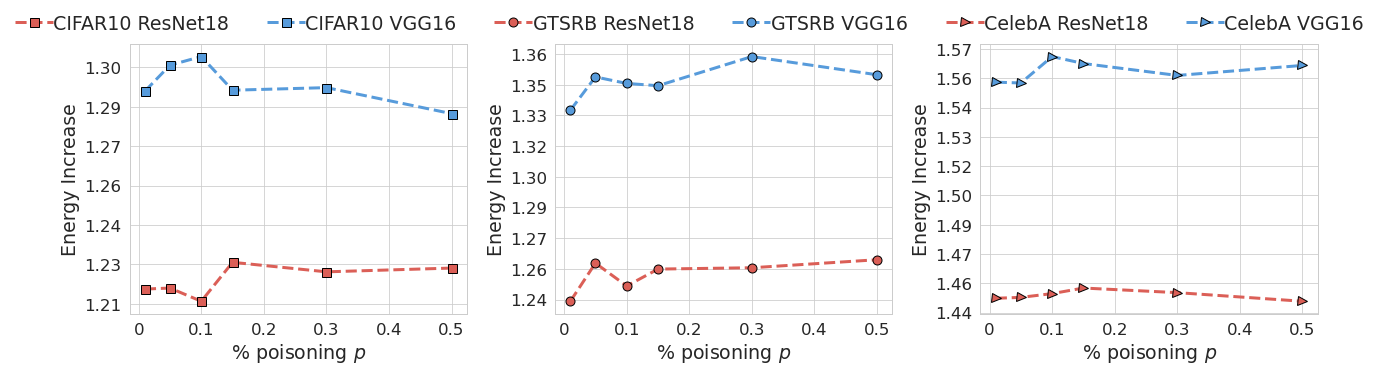

In [40]:
lb = 1
budget_lst = [0.01, 0.02, 0.05, 0.10, 0.15, 0.30, 0.50]
budget_results = []
file = pd.read_csv('/ceph/csedu-scratch/project/jlintelo/stargan/results/sponge_metrics.csv')

for i, model in enumerate(['sponge0','sponge1','sponge2','sponge3','sponge4','sponge5']):
    best_sigma, best_lb = get_sigma_lb(model_j, dataset_d)
    budget_results.append([])

    for j, budget in enumerate(budget_lst):

        name = f'{model}_{budget}_stats.pk'

        exp_stats_budget = deserialize(f'experimental_results/{dataset_d}/{model_j}/exp_stats/{exp_name_budget}')
            sponge_stats_budget = exp_stats_budget['sponge_stats']
            
            budget_results[d][j].append(sponge_stats_budget['increase_ratio']) #increase_ratio
        

sns.set_context("paper", font_scale=1.9, rc={"lines.linewidth": 3})
net_name = ['ResNet18', 'VGG16']

marker_ds = ['s', 'o', '>']
palette = sns.color_palette("hls",7) 
idx_0, idx_1 = (0, 4)
color = [palette[idx_0], palette[idx_1]]

fig, axs = plt.subplots(1,3, figsize=(18,5))
axs = axs.flatten()

for d, dataset_d in enumerate(['CIFAR10', 'GTSRB', 'CelebA']):
    label = ''
    for j, model_j in enumerate(['resnet18', 'VGG16']):
        label=f'{dataset_d} {net_name[j]}'
        axs[d].plot(budget_lst, budget_results[d][j], color=color[j], label=label, 
                 linestyle="--", marker = marker_ds[d], alpha=1,
                 ms= '9', mec= 'black', linewidth=3)
        axs[d].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[d].xaxis.set_major_formatter(FormatStrFormatter('%g'))
        #if i % 2 == 1:
        axs[d].yaxis.set_major_locator(ticker.MultipleLocator(0.015))
    #axs[i].set_xscale('log')
    #axs[i].set_xticks(budget_lst)


    axs[d].set_xlabel('% poisoning $p$', fontsize=19)
    axs[d].set_ylabel('Energy Increase', fontsize=19)
    #axs[d].set_ylim(axs[d].get_ylim()[0]-0.05, axs[d].get_ylim()[1]+0.05)

#fig.legend(labelspacing=1.1, handletextpad=1)
fig.legend(labelspacing=.1, handletextpad=0.1, fontsize=26)

sns.move_legend(fig, "center", bbox_to_anchor=(.5, 1.0), ncol=6, title=None, 
                frameon=False, labelspacing=-0, handletextpad=0.01, fontsize=19)
fig.tight_layout() 
plt.savefig(f'{fig_path}/ablation_budget.pdf', bbox_inches='tight')
plt.show()

In [ ]:
lb = 1
sigma = 1e-04
lb_lst = [0.1, 1, 2.5, 5.0, 10.0]

budget_ratio = []

for d, dataset_d in enumerate(['CIFAR10', 'GTSRB', 'Celeb']):
    budget_ratio.append([])

    for j, model_j in enumerate(['resnet18', 'VGG16']):
        
        sigma, lb = get_sigma_lb(model_j, dataset_d)
        
        budget_ratio[d].append([])
        for i, lb_i in enumerate(lb_lst):
            exp_name_budget = f'{dataset_d}_{model_j}_{budget}_{sigma}_{lb_i}exp_stats.pk'

            exp_stats_budget = deserialize(f'experimental_results/{dataset_d}/{model_j}/exp_stats/{exp_name_budget}')
            sponge_stats_budget = exp_stats_budget['sponge_stats']

            budget_ratio[d][j].append(sponge_stats_budget['test_acc'])

palette = sns.color_palette("hls",7) 
idx_0, idx_1 = (0, 4)
color = [palette[idx_0], palette[idx_1]]

fig, ax1 = plt.subplots(figsize=(5,4))
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel('Accuracy')

net_name = ['ResNet18', 'VGG16']
for d, dataset_d in enumerate(['CIFAR10', 'GTSRB']):
    for j, model_j in enumerate(['resnet18', 'VGG16']):
        ax1.plot(lb_lst, budget_ratio[d][j], color=color[j], label=f'{dataset_d} {net_name[j]}', 
                 linestyle="--", marker = marker_ds[d], alpha=1,
                 ms= '8', mec= 'black', linewidth=3)

fig.legend(labelspacing=1.1, handletextpad=1)
sns.move_legend(fig, "center", bbox_to_anchor=(.5, 1.01), ncol=2, title=None, frameon=False)
plt.xticks(lb_lst)
fig.tight_layout() 
plt.savefig(f'{fig_path}/ablation_lambda_test_acc_all.pdf', bbox_inches='tight')
plt.show()

In [ ]:
model="VGG16"
dataset = "Celeb"

lb = 1.0
sigma = 1e-06
budget = 0.15

    
data_path = f'{dataset}_{model}_{budget}_{sigma}_{lb}exp_stats.pk'
data = deserialize(f'experimental_results/{dataset}/{model}/exp_stats/{data_path}')
data = data['sponge_stats']

print('Clean con. ratio: ', data['avg_cons_clean'])
print('Sponge con. ratio: ', data['avg_cons_sponge'])
print('Sponge increase ratio: ', data['increase_ratio'])

print()
print('Sponge test acc: ', data['test_acc'])

In [ ]:
lb = 1
sigma = 1e-04
budget = 0.05
lb_lst = [0.1, 1, 2.5, 5.0, 10.0]
sigma_lst = [0.1, 0.01, 1e-03, 1e-04, 1e-05, 1e-06,  1e-08, 1e-10]


lambda_results = []
sigma_results = []
test_results = []
test_sigma_results = []

for d, dataset_d in enumerate(['CIFAR10', 'GTSRB', 'Celeb']):
    sigma_results.append([])
    lambda_results.append([])
    test_results.append([])
    test_sigma_results.append([])

    for j, model_j in enumerate(['resnet18', 'VGG16']):
        
        best_sigma, best_lb = get_sigma_lb(model_j, dataset_d)

        sigma_results[d].append([])
        lambda_results[d].append([])
        test_results[d].append([])
        test_sigma_results[d].append([])

        for i, lb_i in enumerate(lb_lst):
            exp_name_budget = f'{dataset_d}_{model_j}_{budget}_{best_sigma}_{lb_i}exp_stats.pk'

            exp_stats_budget = deserialize(f'experimental_results/{dataset_d}/{model_j}/exp_stats/{exp_name_budget}')
            sponge_stats_budget = exp_stats_budget['sponge_stats']

            #lambda_results[d][j].append(sponge_stats_budget['avg_cons_sponge'])
            #test_results[d][j].append(sponge_stats_budget['test_acc'])
            
            lambda_results[d][j].append(sponge_stats_budget['ratio_cons_mean'][-1])
            test_results[d][j].append(sponge_stats_budget['valid_accs'][-1])
        
        
        for i, sigma_i in enumerate(sigma_lst):
            exp_name_budget = f'{dataset_d}_{model_j}_{budget}_{sigma_i}_{1}exp_stats.pk'

            exp_stats_budget = deserialize(f'experimental_results/{dataset_d}/{model_j}/exp_stats/{exp_name_budget}')
            sponge_stats_budget = exp_stats_budget['sponge_stats']

            #ratio = sponge_stats_budget['avg_cons_sponge']
            ratio = sponge_stats_budget['ratio_cons_mean'][-1]
            sigma_results[d][j].append(ratio)
            #test_sigma_results[d][j].append(sponge_stats_budget['test_acc'])
            test_sigma_results[d][j].append(sponge_stats_budget['valid_accs'][-1])

In [ ]:
sns.set_context("paper", font_scale=1.9, rc={"lines.linewidth": 3})

plot_list = [sigma_results, test_sigma_results, lambda_results, test_results]
x_axis = [sigma_lst, sigma_lst, lb_lst, lb_lst]
net_name = ['ResNet18', 'VGG16']

marker_ds = ['s', 'o', '>']
palette = sns.color_palette("hls",7) 
idx_0, idx_1 = (0, 4)
color = [palette[idx_0], palette[idx_1]]

fig, axs = plt.subplots(1,4, figsize=(19,4))
axs = axs.flatten()

for i, results in enumerate(plot_list):
    for d, dataset_d in enumerate(['CIFAR10', 'GTSRB', 'CelebA']):
        label = ''
        for j, model_j in enumerate(['resnet18', 'VGG16']):
            if i == 0:
                label=f'{dataset_d} {net_name[j]}'
            axs[i].plot(x_axis[i], results[d][j], color=color[j], label=label, 
                     linestyle="--", marker = marker_ds[d], alpha=1,
                     ms= '9', mec= 'black', linewidth=3)
            axs[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axs[i].xaxis.set_major_formatter(FormatStrFormatter('%g'))
            if i % 2 == 1:
                axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
                axs[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

            #if i <= 1:
            #    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.1))


    axs[0].set_xscale('log')
    axs[1].set_xscale('log')

    axs[i].set_xticks(x_axis[i])


axs[0].set_xlabel('$\sigma$', fontsize=19)
axs[1].set_xlabel('$\sigma$', fontsize=19)

axs[2].set_xlabel('$\lambda$', fontsize=19)
axs[3].set_xlabel('$\lambda$', fontsize=19)

axs[0].set_ylabel('Energy ratio', fontsize=19)
axs[2].set_ylabel('Energy ratio', fontsize=19)
axs[1].set_ylabel('Validation accuracy', fontsize=19)
axs[3].set_ylabel('Validation accuracy', fontsize=19)


#fig.legend(labelspacing=1.1, handletextpad=1)
fig.legend(labelspacing=.1, handletextpad=0.1, fontsize=26)

sns.move_legend(fig, "center", bbox_to_anchor=(.5, 1.0), ncol=6, title=None, 
                frameon=False, labelspacing=-0, handletextpad=0.01, fontsize=19)
fig.tight_layout() 
plt.savefig(f'{fig_path}/ablation_all.pdf', bbox_inches='tight')
plt.show()

### Load Data for Tables

In [ ]:
model="VGG16"
dataset = "Celeb"

lb = 1.0
sigma = 1e-06
budget = 0.15

    
data_path = f'{dataset}_{model}_{budget}_{sigma}_{lb}exp_stats.pk'
data = deserialize(f'experimental_results/{dataset}/{model}/exp_stats/{data_path}')
data = data['sponge_stats']

print('Clean con. ratio: ', data['avg_cons_clean'])
print('Sponge con. ratio: ', data['avg_cons_sponge'])
print('Sponge increase ratio: ', data['increase_ratio'])

print()
print('Sponge test acc: ', data['test_acc'])

In [ ]:
import glob

exp_file_names = glob.glob('experimental_results/comparison/*exp_stats_l2.pk')


for dataset in ['CIFAR10', 'GTSRB', 'Celeb']:
    exp_file_names = glob.glob(f'experimental_results/comparison/{dataset}*exp_stats_l2.pk')

    for exp_name in exp_file_names:
        print(exp_name)
        data = deserialize(exp_name)
        data = data['sponge_stats']

        print('Clean con. ratio: ', data['avg_cons_clean'])
        print('Sponge con. ratio: ', data['avg_cons_sponge'])
        print('Sponge increase ratio: ', data['increase_ratio'])

        print('Sponge test acc: ', data['test_acc'])
        print()
    print("="*100)
